# DSC 540, 7.2 Exercise: Importing, Exploring, and Charting Data



There are three parts to the assignment, following chapters nine and ten in the *Data Wrangling with Pythong: Tools to Make Your Life Easier* text. As always, this Notebook starts with reusable elements (e.g., reading data) and works towards the assignment-specific sections.

In [ ]:
import xlrd
import agate
from xlrd.sheet import ctype_text
import pprint
import matplotlib.pyplot as plt
import json

## Load the Excel spreadsheet data for the October, 2014 UNICEF data set. 
In addition to selecting only the country rows (in the Excel spreadsheet, that's rows 7-114), the column titles are read and stripped of any spaces athe beginning or end. Those column titlesa are output for reference.

One piece of data cleaning I performed was to add a column title to the empty column. This column contains "notes" about the `Total (%)` column.

In [9]:
workbook = xlrd.open_workbook('.unicef_oct_2014.xls')
workbook.nsheets

sheet = workbook.sheets()[0]
title_rows = zip(sheet.row_values(4), sheet.row_values(5))
titles = [t[0] + '' + t[1] for t in title_rows]
titles = [t.strip() for t in titles]
country_rows = [sheet.row_values(r) for r in range(6, 114)]
pprint.pprint(titles)

['Countries and areas',
 'Total (%)',
 'Notes',
 'Sex (%)Male',
 'Female',
 'Place of residence (%)Urban',
 'Rural',
 'Household wealth quintile (%)Poorest',
 'Second',
 'Middle',
 'Fourth',
 'Richest',
 'Reference Year',
 'Data Source']


## 1. Importing Data
Create a function to take an empty list, iterate over the columns and create a full list of all the column types for the dataset. Then load into agate table – make sure to clean the data if you get an error. Follow along with the example in the book on the pages listed.

In [52]:
text_type = agate.Text()
number_type = agate.Number()
boolean_type = agate.Boolean()
date_type = agate.Date()
example_row = sheet.row(6)

# Set the data types based on a single example row, since all rows are the same.
types = []
for v in row:
    value_type = ctype_text[v.ctype]
    if value_type == 'text':
        types.append(text_type)
    elif value_type == 'number':
        types.append(number_type)
    elif value_type == 'xldate':
        types.append(date_type)
    else:
        types.append( text_type)
return types

def remove_bad_chars(val):
    if val == '-':
        return None
    return val

def get_new_array(old_array, function_to_clean):
    new_arr = []
    for row in old_array:
        cleaned_row = [function_to_clean(rv) for rv in row]
        new_arr.append(cleaned_row)
    return new_arr

cleaned_rows = get_new_array(country_rows, remove_bad_chars)

table = agate.Table(cleaned_rows, titles, types)
table.print_table(max_columns=7)

| Countries and areas  | Total (%) | Notes | Sex (%)Male | Female | Place of residenc... | Rural | ... |
| -------------------- | --------- | ----- | ----------- | ------ | -------------------- | ----- | --- |
| Afghanistan          |      10.3 |       |        11.0 |    9.6 |                  7.9 |  10.8 | ... |
| Albania              |       5.1 | y     |         6.2 |    3.9 |                      |       | ... |
| Algeria              |       4.7 | y     |         5.5 |    3.9 |                  3.9 |   5.6 | ... |
| Angola               |      23.5 |       |        22.1 |   24.8 |                      |       | ... |
| Argentina            |       4.4 |       |         4.8 |    3.9 |                      |       | ... |
| Armenia              |       3.9 |       |         4.7 |    2.9 |                  2.4 |   6.0 | ... |
| Azerbaijan           |       6.5 | y     |         7.5 |    5.4 |                  2.1 |  10.7 | ... |
| Bahrain              |       4.6 |       |         6.

## 2. Exploring Table Functions 
### a. Which countries have the highest rates of child labor?

In [54]:
############ Part a ################
high_rates = table.order_by('Total (%)', reverse=True).limit(10)
for r in high_rates.rows:
    print(r['Countries and areas'],r['Total (%)'])

Somalia 49.0
Cameroon 41.7
Zambia 40.6
Burkina Faso 39.2
Guinea-Bissau 38.0
Ghana 33.9
Nepal 33.9
Peru 33.5
Niger 30.5
Central African Republic 28.5


### b. Which countries have the most girls working?

In [22]:
############ Part b ################
female_data = table.where(lambda r: r['Female'] is not None)
most_females = female_data.order_by('Female', reverse=True).limit(10)
for r in most_females.rows:
    print('{}: {}%'.format(r['Countries and areas'], r['Female']))

Somalia: 53.6%
Cameroon: 40.2%
Zambia: 39.5%
Nepal: 37.8%
Guinea-Bissau: 36.4%
Peru: 36.3%
Burkina Faso: 36.0%
Ghana: 34.0%
Rwanda: 30.4%
Niger: 30.1%


### c. What is the average percentage of child labor in cities?

In [44]:
############ Part c ################
has_poor = table.where(lambda r: r['Place of residence (%)Urban'] is not None)
avg_percent = has_poor.aggregate(agate.Mean('Place of residence (%)Urban'))
print('Average percentage of child labor in cities: {}%'.format(round(avg_percent, 2)))

Average percentage of child labor in cities: 10.41%


### d. Find a row with more than 50% of rural child labor.

In [47]:
############ Part d ################
has_poor = table.where(lambda r: r['Rural'] is not None)
first_match = has_poor.find(lambda x: x['Rural'] > 50)
print('The first row with > 50% rural child labor is', first_match['Countries and areas'])

The first row with > 50% rural child labor is Bolivia (Plurinational State of)


### e. Rank the worst offenders in terms of child labor percentages by country.

In [49]:
############ Part e ################
ranked = table.compute([('Total Child Labor Rank', agate.Rank('Total (%)', reverse=True)), ])
for row in ranked.order_by('Total (%)', reverse=True).limit(20).rows:
    print(row['Total Child Labor Rank'], '\t', row['Countries and areas'], row['Total (%)'])

1 	 Somalia 49.0
2 	 Cameroon 41.7
3 	 Zambia 40.6
4 	 Burkina Faso 39.2
5 	 Guinea-Bissau 38.0
6 	 Ghana 33.9
6 	 Nepal 33.9
8 	 Peru 33.5
9 	 Niger 30.5
10 	 Central African Republic 28.5
10 	 Rwanda 28.5
12 	 Guinea 28.3
12 	 Togo 28.3
14 	 Equatorial Guinea 27.8
15 	 Paraguay 27.6
16 	 Ethiopia 27.4
17 	 Bolivia (Plurinational State of) 26.4
17 	 Côte d'Ivoire 26.4
19 	 Burundi 26.3
20 	 Chad 26.1


### f. Calculate the percentage of children not involved in child labor.

In [67]:
############ Part f ################
def reverse_percent(row):
    return 100 - row['Total (%)']

ranked = table.compute([('Children not working (%)', agate.Formula(number_type, reverse_percent)),])
ranked = ranked.compute([('Total Child Labor Rank', agate.Rank('Children not working (%)')),])
percent_not_working = ranked.aggregate(agate.Mean('Children not working (%)'))
print('The total % of children not working is {}%'.format(round(percent_not_working, 2)), '\n')

print('The best countries for children not working are:')
for row in ranked.order_by('Total (%)', reverse=False).limit(20).rows:
    print(row['Countries and areas'], row['Total (%)'], row['Children not working (%)'])

The total % of children not working is 85.22% 

The best countries for children not working are:
Trinidad and Tobago 0.7 99.3
Romania 0.9 99.1
Belarus 1.4 98.6
Jordan 1.6 98.4
Lebanon 1.9 98.1
Tunisia 2.1 97.9
Kazakhstan 2.2 97.8
Ukraine 2.4 97.6
Bhutan 2.9 97.1
Jamaica 3.3 96.7
Portugal 3.4 96.6
Kyrgyzstan 3.6 96.4
Armenia 3.9 96.1
Saint Lucia 3.9 96.1
Syrian Arab Republic 4.0 96.0
Costa Rica 4.1 95.9
Suriname 4.1 95.9
Timor-Leste 4.2 95.8
Argentina 4.4 95.6
Serbia 4.4 95.6


## 3. Charting with matplotlib
### a. Chart the perceived corruption scores compared to the child labor percentages.
Have to setup some data before charting.

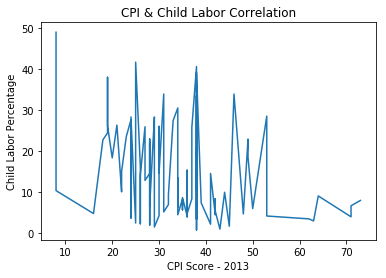

In [72]:
def float_to_str(float):
    return str(float)

def get_table(new_arr, types, titles):
    try:
        table = agate.Table(new_arr, titles, types)
        return table
    except Exception as e:
        print(e)
        
def get_types(row):
    types = []
    for v in row:
        value_type = ctype_text[v.ctype]
        if value_type == 'text':
            types.append(text_type)
        elif value_type == 'number':
            types.append(number_type)
        elif value_type == 'xldate':
            types.append(date_type)
        else:
            types.append( text_type)
    return types
        
cpi_workbook = xlrd.open_workbook('../Pycharm/data/corruption_perception_index.xls')
cpi_sheet = cpi_workbook.sheets()[0]
for r in range(cpi_sheet.nrows):
    #print(r, cpi_sheet.row_values(r))
    cpi_title_rows = zip(cpi_sheet.row_values(1), cpi_sheet.row_values(2))
    cpi_titles = [t[0] + '' + t[1] for t in cpi_title_rows]
    cpi_titles = [t.strip() for t in cpi_titles]
    cpi_rows = [cpi_sheet.row_values(r) for r in range(3, cpi_sheet.nrows)]
    cpi_types = get_types(cpi_sheet.row(3))

def get_table(new_arr, types, titles):
    try:
        table = agate.Table(new_arr, titles, types)
        return table
    except Exception as e:
        print(e)

cpi_titles[0] = cpi_titles[0] + ' Duplicate'

cpi_table = get_table(cpi_rows, cpi_types, cpi_titles)
cpi_rows = get_new_array(cpi_rows, float_to_str)
cpi_table = get_table(cpi_rows, cpi_types, cpi_titles)

cpi_and_cl = cpi_table.join(ranked, 'Country / Territory', 'Countries and areas', inner=True)

# Here is the actual plot code
plt.plot(cpi_and_cl.columns['CPI 2013 Score'], cpi_and_cl.columns['Total (%)'])
plt.xlabel('CPI Score - 2013')
plt.ylabel('Child Labor Percentage')
plt.title('CPI & Child Labor Correlation')
plt.show()

### b. Chart the perceived corruption scores compared to the child labor percentages using only the worst offenders.

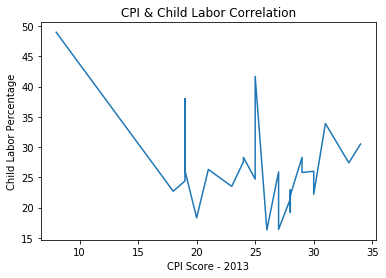

In [73]:
cl_mean = cpi_and_cl.aggregate(agate.Mean('Total (%)'))
cpi_mean = cpi_and_cl.aggregate(agate.Mean('CPI 2013 Score'))

def highest_rates(row):
    if row['Total (%)'] > cl_mean and row['CPI 2013 Score'] < cpi_mean:
        return True
    return False

highest_cpi_cl = cpi_and_cl.where(lambda x: highest_rates(x))

# Here is the actual plot code
plt.plot(highest_cpi_cl.columns['CPI 2013 Score'], highest_cpi_cl.columns['Total (%)'])
plt.xlabel('CPI Score - 2013')
plt.ylabel('Child Labor Percentage')
plt.title('CPI & Child Labor Correlation')
plt.show()
